In [1]:
# Loosely inspired from caiman, but they only do translation, not rotation
import pandas as pd
import matplotlib.pyplot as plt
from skimage import transform
from skimage.transform import warp
import numpy as np
import zarr
import napari
from DLC_for_WBFM.utils.postprocessing.base_cropping_utils import get_crop_coords3d
from DLC_for_WBFM.utils.feature_detection.utils_rigid_alignment import calc_warp_ECC
from tqdm.auto import tqdm
from DLC_for_WBFM.utils.video_and_data_conversion.import_video_as_array import get_single_volume
from DLC_for_WBFM.utils.projects.utils_project import load_config
from pathlib import Path
from DLC_for_WBFM.utils.projects.utils_project import safe_cd
import cv2
from DLC_for_WBFM.utils.feature_detection.visualization_tracks import visualize_tracks
from DLC_for_WBFM.utils.preprocessing.utils_tif import PreprocessingSettings
from DLC_for_WBFM.utils.preprocessing.utils_tif import perform_preprocessing
from DLC_for_WBFM.utils.feature_detection.utils_features import build_features_and_match_2volumes, extract_map1to2_from_matches
from scipy.ndimage import distance_transform_edt
%load_ext autoreload
import itertools
import pickle
%autoreload 2

In [2]:

project_path = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\project_config.yaml"
cfg = load_config(project_path)

red_btf = cfg['red_bigtiff_fname']
num_z = cfg['dataset_params']['num_slices']

project_dir = Path(project_path).parent

with safe_cd(project_dir):
    train_fname = Path(cfg['subfolder_configs']['training_data'])
    train_cfg = dict(load_config(train_fname))
    
    p_fname = train_cfg['preprocessing_config']
    p = PreprocessingSettings.load_from_yaml(p_fname)

In [3]:
# Get data
i_ref = 300
ref_frame_raw = get_single_volume(red_btf, i_ref, num_z, 0.15)

i_test = 301
test_frame_raw = get_single_volume(red_btf, i_test, num_z, 0.15)

In [683]:
# Remove background
# background = 1.5*np.mean(ref_frame)
# ref_frame = np.where(ref_frame>background, ref_frame, 0)
# test_frame = np.where(test_frame>background, test_frame, 0)

In [4]:
# Do z-alignment (preprocessing)

ref_frame = perform_preprocessing(ref_frame_raw, p)
test_frame = perform_preprocessing(test_frame_raw, p)

In [37]:
# Get segmentation
# fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\4-traces\reindexed_masks.zarr"
fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\1-segmentation\masks_1500.zarr"
z = zarr.open(fname)

ref_seg = np.array(z[i_ref,...])
test_seg = np.array(z[i_test,...])

# And metadata
fname = r"Y:\shared_projects\wbfm\dlc_stacks\Charlie-worm3-long\1-segmentation\metadata_1500.pickle"
with open(fname, 'rb') as f:
    seg_metadata = pickle.load(f)

In [33]:
# CHECK
viewer = napari.view_image(ref_frame)
# viewer.add_image(ref_frame_raw)
# viewer.add_image(test_frame)
viewer.add_labels(ref_seg)
# viewer.add_labels(test_seg)

<Labels layer 'ref_seg' at 0x1643f97e988>

In [32]:
# Detect features and match between frames
all_locs0, all_locs1, keypoints0, keypoints1, matches = build_features_and_match_2volumes(
    ref_frame, test_frame, use_GMS=False, verbose=0
)

  0%|          | 0/32 [00:00<?, ?it/s]

In [33]:
# Build an affine motion model and apply
zxy0 = np.array(all_locs0[:,1:], dtype='float64')
zxy1 = np.array(all_locs1[:,1:], dtype='float64')
trans = transform.estimate_transform('euclidean', zxy1, zxy0)
h_2d, inliers = cv2.estimateAffinePartial2D(zxy1, zxy0)
# val, h_3d, inliers = cv2.estimateAffine3D(all_locs1, all_locs0, confidence=0.999)
# h_2d = h_3d[1:, 1:]

if h_2d is not None:
    # And translate ALL the neurons (not only matches)
    
    rotated_frame = np.zeros_like(test_frame)
    for i, f in enumerate(test_frame):
        sz = (f.shape[1], f.shape[0])
#         out = cv2.warpAffine(f, h_2d, dsize=sz)
        out = cv2.warpAffine(f, trans.params[:2,:], dsize=sz)
        rotated_frame[i,...] = out
else:
    print("No rotation found")
#     rotated_matches = cv2.transform(np.array([test_matches]), h_3d)[0]


In [34]:
out = warp(f, trans)
# np.where(out)

Text(0.5, 1.0, 'Overlay after affine transformation')

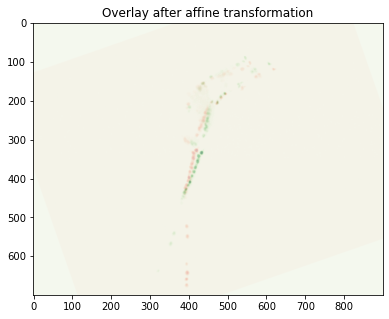

In [35]:
# CHECK
i_slice = 17

plt.figure(figsize=(25,5))
plt.imshow(rotated_frame[i_slice,...], alpha=0.5, cmap="Reds")
plt.imshow(ref_frame[i_slice,...], alpha=0.5, cmap="Greens")
plt.title("Overlay after affine transformation")


In [38]:
# Do pixel-based registration between neurons
# Neurons are defined by segmentation in the reference image

i_seg = 7
# Get a centroid
centroid = seg_metadata[i_ref].iloc[i_seg]['centroids']

# Get a cropped cube in both volumes
z, x, y = get_crop_coords3d((16,) + centroid[1:], crop_sz=(9, 128, 128), clip_sz=None)
ref_crop = ref_frame[:, x[0]:x[-1], y[0]:y[-1]]
rotated_crop = rotated_frame[:, x[0]:x[-1], y[0]:y[-1]]

test_crop_full_size = np.zeros_like(test_frame)
test_crop_full_size[z[0]:z[-1], x[0]:x[-1], y[0]:y[-1]] = test_frame[z[0]:z[-1], x[0]:x[-1], y[0]:y[-1]]

Text(0.5, 1.0, 'Overlay after global affine transformation')

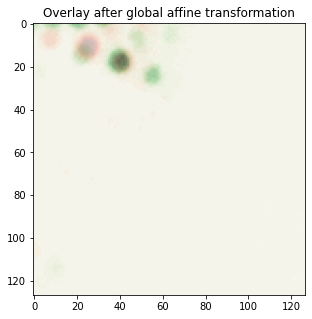

In [39]:
# CHECK
# viewer = napari.view_image(ref_crop)
# viewer.add_image(test_crop)
# CHECK
i_slice = 2

plt.figure(figsize=(25,5))
plt.imshow(rotated_crop[i_slice,...], alpha=0.5, cmap="Reds")
plt.imshow(ref_crop[i_slice,...], alpha=0.5, cmap="Greens")
plt.title("Overlay after global affine transformation")

In [40]:
# Redo feature matching on the crop
def get_warp_via_features_from_imgs(ref_frame, test_frame, apply_to_slices=False):
    # 3d
    all_locs0, all_locs1, all_kp0, all_kp1, all_matches = build_features_and_match_2volumes(
        ref_frame, test_frame, use_GMS=False, verbose=0, start_plane=5
    )
    if len(all_locs0) == 0:
        print("No matches found")
        return all_kp0, all_kp1
    zxy0 = np.array(all_locs0[:,1:], dtype='float64')
    zxy1 = np.array(all_locs1[:,1:], dtype='float64')
    # Try skimage
#     h_2d = transform.estimate_transform(zxy1, zxy0)[:2,:]
    h_2d, inliers = cv2.estimateAffinePartial2D(zxy1, zxy0, confidence=0.99)
#     h_2d, inliers = cv2.estimateRigidTransform(zxy1, zxy0, confidence=0.99)
    
    if h_2d is not None:
        if apply_to_slices:
            rotated_frame = np.zeros_like(test_frame)
            for i, f in enumerate(test_frame):
                sz = (f.shape[1], f.shape[0])
                out = cv2.warpAffine(f, h_2d, dsize=sz)
                rotated_frame[i,...] = out
            return h_2d, rotated_frame
        else:
            return h_2d, None
    else:
        print("No rotation found")
        return None, None

In [41]:
h_2d, rotated_crop2 = get_warp_via_features_from_imgs(ref_crop, rotated_crop)

  0%|          | 0/32 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Overlay after global and local affine transformations')

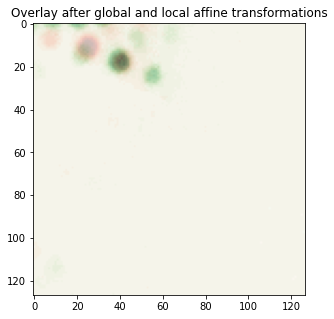

In [43]:
# CHECK
i_slice = 2

plt.figure(figsize=(25,5))
plt.imshow(rotated_crop[i_slice,...], alpha=0.5, cmap="Reds")
plt.imshow(ref_crop[i_slice,...], alpha=0.5, cmap="Greens")
plt.title("Overlay after global and local affine transformations")

In [378]:
# Do crop on only the test frame
h_2d, rotated_crop_total = get_warp_via_features_from_imgs(ref_frame, test_crop_full_size)

  0%|          | 0/32 [00:00<?, ?it/s]

Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping
Found no keypoints on at least one frame; skipping


In [379]:

rotated_frame_from_crop = np.zeros_like(test_frame)
for i, f in enumerate(test_frame):
    sz = (f.shape[1], f.shape[0])
    out = cv2.warpAffine(f, h_2d, dsize=sz)
    rotated_frame_from_crop[i,...] = out

Text(0.5, 1.0, 'Overlay after global and local affine transformations')

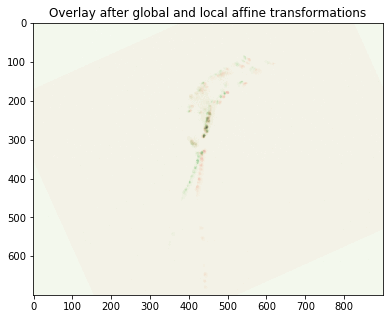

In [468]:
# CHECK
i_slice = 15

plt.figure(figsize=(15,5))
# plt.imshow(test_frame[i_slice,...], alpha=0.5, cmap="Reds")
plt.imshow(rotated_frame_from_crop[i_slice,...], alpha=0.5, cmap="Reds")
plt.imshow(ref_frame[i_slice,...], alpha=0.5, cmap="Greens")
plt.title("Overlay after global and local affine transformations")

In [44]:
# Build a flow field from the rotation matrix
def flow_field_from_matrix(shape, A):
    x, y = shape
    xx, yy = np.arange(x), np.arange(y)
#     xx = x
#     yy = y
#     xx = x - np.mean(x)
#     yy = y - np.mean(y)
#     flow = np.zeros((len(x), len(y), 2))
#     A = all_warp_mat[3]
    A = cv2.invertAffineTransform(A)
    
#     A1 = A[:,:-1]
#     offset = A[:,-1]
#     offset = np.expand_dims(A[:,-1], -1)
    all_xy = np.array([[yy[i_y], xx[i_x], 1] for i_x, i_y in itertools.product(range(x), range(y))])
    flow_long = A@all_xy.T
    flow0 = np.reshape(flow_long[0,:], (x, y), order='A')
    flow1 = np.reshape(flow_long[1,:], (x, y), order='A')
    flow = np.stack([flow0, flow1], axis=2).astype('float32')
#     for i_x, i_y in itertools.product(range(len(x)), range(len(y))):
#         xy = np.array([xx[i_x], yy[i_y]])
# #         xy = np.array([yy[i_y], xx[i_x]])
#         flow[i_x, i_y, :] = A1@xy + offset
    return flow

In [76]:
flow = flow_field_from_matrix(test_frame.shape[1:], h_2d)

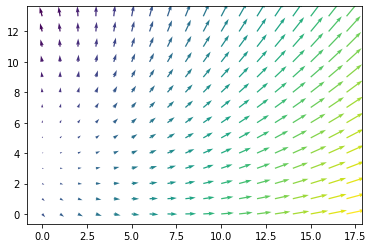

In [562]:
downsample = 50
C = flow[::downsample,::downsample,0] / np.max(flow[::downsample,::downsample,0])
# # opt = {'angles':'xy', 'scale_units':'xy', 'scale':downsample}
plt.quiver(flow[::downsample,::downsample,0], flow[::downsample,::downsample,1], C)

In [516]:
def warp_flow(img, flow, apply_directly=False):
    # From:
    # https://github.com/opencv/opencv/blob/master/samples/python/opt_flow.py#L50-L56
    # apply_directly should be False if the output is from 
    if not apply_directly:
        h, w = flow.shape[:2]
        flow = -flow
        flow[:,:,0] += np.arange(w)
        flow[:,:,1] += np.arange(h)[:,np.newaxis]
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

Text(0.5, 1.0, 'Overlay after global and local affine transformations')

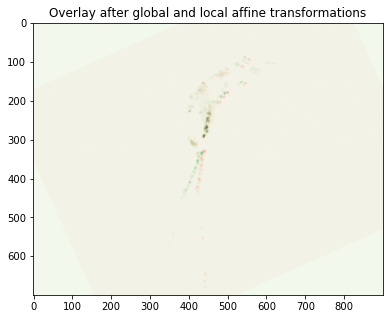

In [551]:
# CHECK
i_slice = 15

plt.figure(figsize=(15,5))
plt.imshow(warp_flow(test_frame[i_slice,...], flow, apply_directly=True), alpha=0.5, cmap="Reds")
# plt.imshow(rotated_frame_from_crop[i_slice,...], alpha=0.5, cmap="Reds")
plt.imshow(ref_frame[i_slice,...], alpha=0.5, cmap="Greens")
plt.title("Overlay after global and local affine transformations")

# Build a function and redo for multiple neurons

In [135]:
# Build a flow field from the rotation matrix
def flow_field_from_matrix(shape, A):
    if A is None or len(A)==0:
        return None
    x, y = shape
    xx, yy = np.arange(x), np.arange(y)
    A = cv2.invertAffineTransform(A)
    
    all_xy = np.array([[yy[i_y], xx[i_x], 1] for i_x, i_y in itertools.product(range(x), range(y))])
    flow_long = A@all_xy.T
    flow0 = np.reshape(flow_long[0,:], (x, y), order='A')
    flow1 = np.reshape(flow_long[1,:], (x, y), order='A')
    flow = np.stack([flow0, flow1], axis=2).astype('float32')
    return flow

# Redo feature matching on the crop
def get_warp_via_features_from_imgs(ref_frame, test_frame, apply_to_slices=False):
    # 3d
    all_locs0, all_locs1, all_kp0, all_kp1, all_matches = build_features_and_match_2volumes(
        ref_frame, test_frame, use_GMS=True, verbose=0, start_plane=5, matches_to_keep=0.2
    )
    if len(all_locs0) == 0:
        print("No matches found")
        return all_kp0, all_kp1
    zxy0 = np.array(all_locs0[:,1:], dtype='float64')
    zxy1 = np.array(all_locs1[:,1:], dtype='float64')
    # Try skimage
    h_2d = transform.estimate_transform('euclidean', zxy1, zxy0)[:2,:]
#   h_2d, inliers = cv2.estimateAffinePartial2D(zxy1, zxy0, confidence=0.99)
    
    rotated_frame = None
    if h_2d is not None:
        if apply_to_slices:
            rotated_frame = np.zeros_like(test_frame)
            for i, f in enumerate(test_frame):
                sz = (f.shape[1], f.shape[0])
                out = cv2.warpAffine(f, h_2d, dsize=sz)
                rotated_frame[i,...] = out
    else:
        print("No rotation found")
        return None, None
    return h_2d, rotated_frame, zxy0, zxy1

def vector_field_to_flow(vf):
    h, w = vf.shape[:2]
    flow = vf.copy()
    flow = -flow
    flow[:,:,0] += np.arange(w)
    flow[:,:,1] += np.arange(h)[:,np.newaxis]
    return flow


def flow_to_vector_field(flow):
    h, w = flow.shape[:2]
    vf = flow.copy()
    vf[:,:,0] -= np.arange(w)
    vf[:,:,1] -= np.arange(h)[:,np.newaxis]
    vf = -vf
    return vf

def warp_flow(img, flow, apply_directly=False):
    # From:
    # https://github.com/opencv/opencv/blob/master/samples/python/opt_flow.py#L50-L56
    # apply_directly should be False if the output is from 
    if not apply_directly:
        flow = vector_field_to_flow(flow)
    res = cv2.remap(img, flow, None, cv2.INTER_LINEAR)
    return res

In [155]:
def get_cropped_image(centroid, test_frame):
    # Get a cropped cube in both volumes
    z, x, y = get_crop_coords3d(centroid, crop_sz=(9, 128, 128), clip_sz=None)

    test_crop_full_size = np.zeros_like(test_frame)
#     test_crop_full_size[z[0]:z[-1], x[0]:x[-1], y[0]:y[-1]] = test_frame[z[0]:z[-1], x[0]:x[-1], y[0]:y[-1]]
    test_crop_full_size[:, x[0]:x[-1], y[0]:y[-1]] = test_frame[:, x[0]:x[-1], y[0]:y[-1]]
    return test_crop_full_size


def get_flow_field_from_centroid(centroid, ref_frame, test_frame):
    cropped_test_frame = get_cropped_image(centroid, test_frame)
    h_2d, _, _, _ = get_warp_via_features_from_imgs(ref_frame, cropped_test_frame)
    if h_2d is None:
        return None, None
    flow = flow_field_from_matrix(cropped_test_frame.shape[1:], h_2d)
    weights = cropped_test_frame > 0
    return flow, weights


def dist_func(x, thresh):
    if x == 0 or x > thresh:
        return 0
    else:
        return 1.0/x


def combine_flow_fields(all_flows, all_weights, outliers, err_thresh=30):
    # Weight each flow field by how accurate the overlap is
    flow = np.zeros_like(all_flows[0])
    overlapping_weights = np.ones(flow.shape[:-1])
    for i, (w, f) in tqdm(enumerate(zip(all_weights, all_flows))):
        if i in outliers or f is None or len(f)==0:
            continue
        mask = np.max(w,axis=0)
        # Get both raw patches
        centroid = seg_metadata[i_ref].iloc[i]['centroids']
        i_slice = int(centroid[0])
        this_ref = np.where(mask, ref_frame[i_slice,...], 0)
        this_test = np.where(mask, test_frame[i_slice,...], 0)
        
        # Apply flow
#         this_flow = warp_flow(this_test, f, apply_directly=True)
        
        # Calculate weight matrix based on error, with hard threshold
#         err_mat = np.square(this_ref - this_flow)
#         percent_err = np.sum(err_mat) / np.sum(this_ref)
#         print(percent_err)
#         if percent_err > 1.5:
#             continue
#         print(np.max(err_mat[mask]))
#         func = lambda x: dist_func(x, err_thresh)
#         vfunc = np.vectorize(func)
#         w_dist = vfunc(err_mat)

#         w_dist = mask
        w_dist = distance_transform_edt(mask)
        overlapping_weights += w_dist
#         flow[...,0] += np.where(w_binary, f[...,0], 0)
#         flow[...,1] += np.where(w_binary, f[...,1], 0)
        flow[...,0] += np.multiply(f[...,0], w_dist)
        flow[...,1] += np.multiply(f[...,1], w_dist)
    tmp = np.stack([overlapping_weights, overlapping_weights], axis=-1)
    flow = np.divide(flow, tmp)
    return flow, overlapping_weights

In [149]:
all_flows, all_weights = [], []
num_neurons = len(seg_metadata[i_ref])
for i_seg in tqdm(range(num_neurons), total=num_neurons):
    # Get a centroid
    centroid = seg_metadata[i_ref].iloc[i_seg]['centroids']
    flow, weights = get_flow_field_from_centroid(centroid, ref_frame, test_frame)
    all_flows.append(flow)
    all_weights.append(weights)

  0%|          | 0/163 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

No matches found


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

No matches found


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

No matches found


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

No matches found


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

No matches found


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

No matches found


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

No matches found


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

No matches found


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

No matches found


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

No matches found


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

No matches found


In [156]:
outliers = []
# outliers = [0, 88]
# outliers = [13, 17, 32, 74, 88, 89, 93, 94, 96, 106, 108, 111, 121, 123, 129, 149, 153, 155, 157, 159, 162]
flow, overlapping_weights = combine_flow_fields(all_flows, all_weights, outliers)

0it [00:00, ?it/s]

In [150]:
# CHECK
i_slice = 18

from ipywidgets import interact

def f(i):
    plt.figure(figsize=(45,25))
    centroid = seg_metadata[i_ref].iloc[i]['centroids']
    
    i_slice = int(centroid[0])
    
    plt.imshow(warp_flow(test_frame[i_slice,...], all_flows[i], apply_directly=True), alpha=0.5, cmap="Reds")
    # plt.imshow(rotated_frame_from_crop[i_slice,...], alpha=0.5, cmap="Reds")
    
    tmp = get_cropped_image(centroid, ref_frame)
    plt.imshow(tmp[i_slice,...], alpha=0.5, cmap="Greens")
#     plt.imshow(ref_frame[i_slice,...], alpha=0.5, cmap="Greens")
    plt.title(f"Overlay after global and local affine transformations (slice {i_slice})")

interact(f, i=(0, len(all_flows)))

interactive(children=(IntSlider(value=81, description='i', max=163), Output()), _dom_classes=('widget-interact…

<function __main__.f(i)>

<Figure size 3240x1800 with 0 Axes>

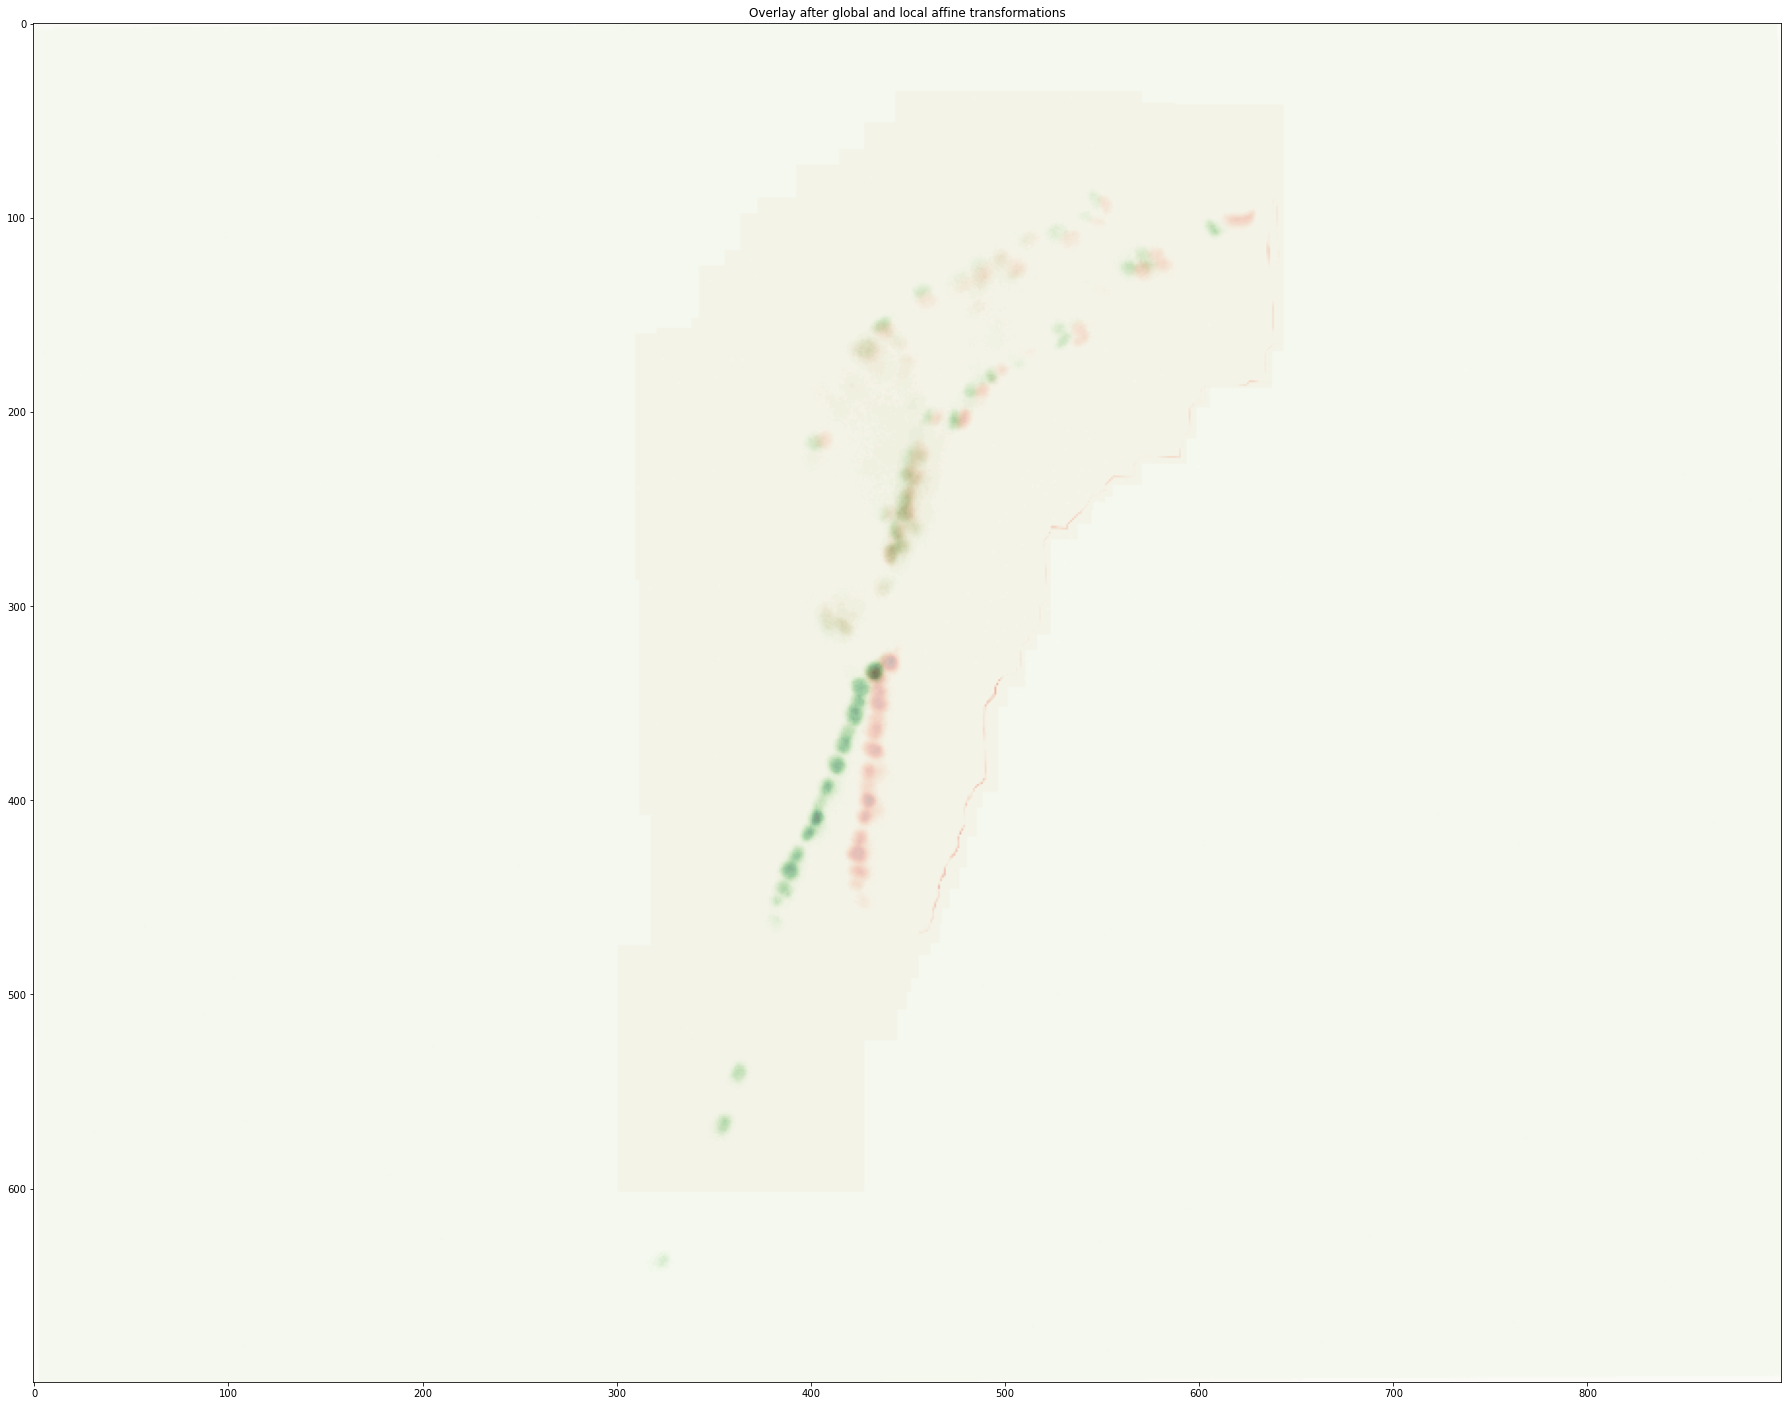

In [157]:

plt.figure(figsize=(45,25))
test_frame_flow = warp_flow(test_frame[i_slice,...], flow.astype('float32'), apply_directly=True)
plt.imshow(test_frame_flow, alpha=0.5, cmap="Reds")
# plt.imshow(rotated_frame_from_crop[i_slice,...], alpha=0.5, cmap="Reds")
plt.imshow(ref_frame[i_slice,...], alpha=0.5, cmap="Greens")
plt.title("Overlay after global and local affine transformations")
plt.savefig("Affine_tests.png")

In [696]:
# downsample = 10
# C = flow[::downsample,::downsample,0] / np.max(flow[::downsample,::downsample,0])
# # # opt = {'angles':'xy', 'scale_units':'xy', 'scale':downsample}
# plt.quiver(flow[::downsample,::downsample,0], flow[::downsample,::downsample,1], C)

# Use skimage piecewise transform

  0%|          | 0/32 [00:00<?, ?it/s]

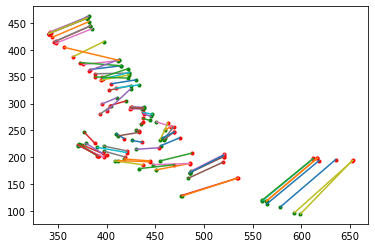

In [196]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data

# Reuse feature matches
all_locs0, all_locs1, all_kp0, all_kp1, all_matches = build_features_and_match_2volumes(
    ref_frame, test_frame, use_GMS=True, verbose=0, start_plane=5, matches_to_keep=0.1
)
if len(all_locs0) == 0:
    print("No matches found")
zxy0 = np.array(all_locs0[:,1:], dtype='float64')
zxy1 = np.array(all_locs1[:,1:], dtype='float64')
plt.plot(zxy0[:,0], zxy0[:,1], 'g.')
plt.plot(zxy1[:,0], zxy1[:,1], 'r.')
for x0, x1 in zip(zxy0, zxy1):
    plt.plot([x0[0], x1[0]], [x0[1], x1[1]])

In [193]:
i_slice = 15
image = test_frame[i_slice,...]
# src = ref_frame[i_slice,...]

# rows, cols = image.shape[0], image.shape[1]
# src_cols = np.linspace(0, cols, 20)
# src_rows = np.linspace(0, rows, 10)
# src_rows, src_cols = np.meshgrid(src_rows, src_cols)
# src = np.dstack([src_cols.flat, src_rows.flat])[0]

# Transform points
tform = PiecewiseAffineTransform()
tform.estimate(zxy0, zxy1)

# out_rows = image.shape[0] - 1.5 * 50
# out_cols = cols
out_rows, out_cols = image.shape[0], image.shape[1]
out = warp(image, tform, output_shape=(out_rows, out_cols))

Text(0.5, 1.0, 'skimage piecewise affine')

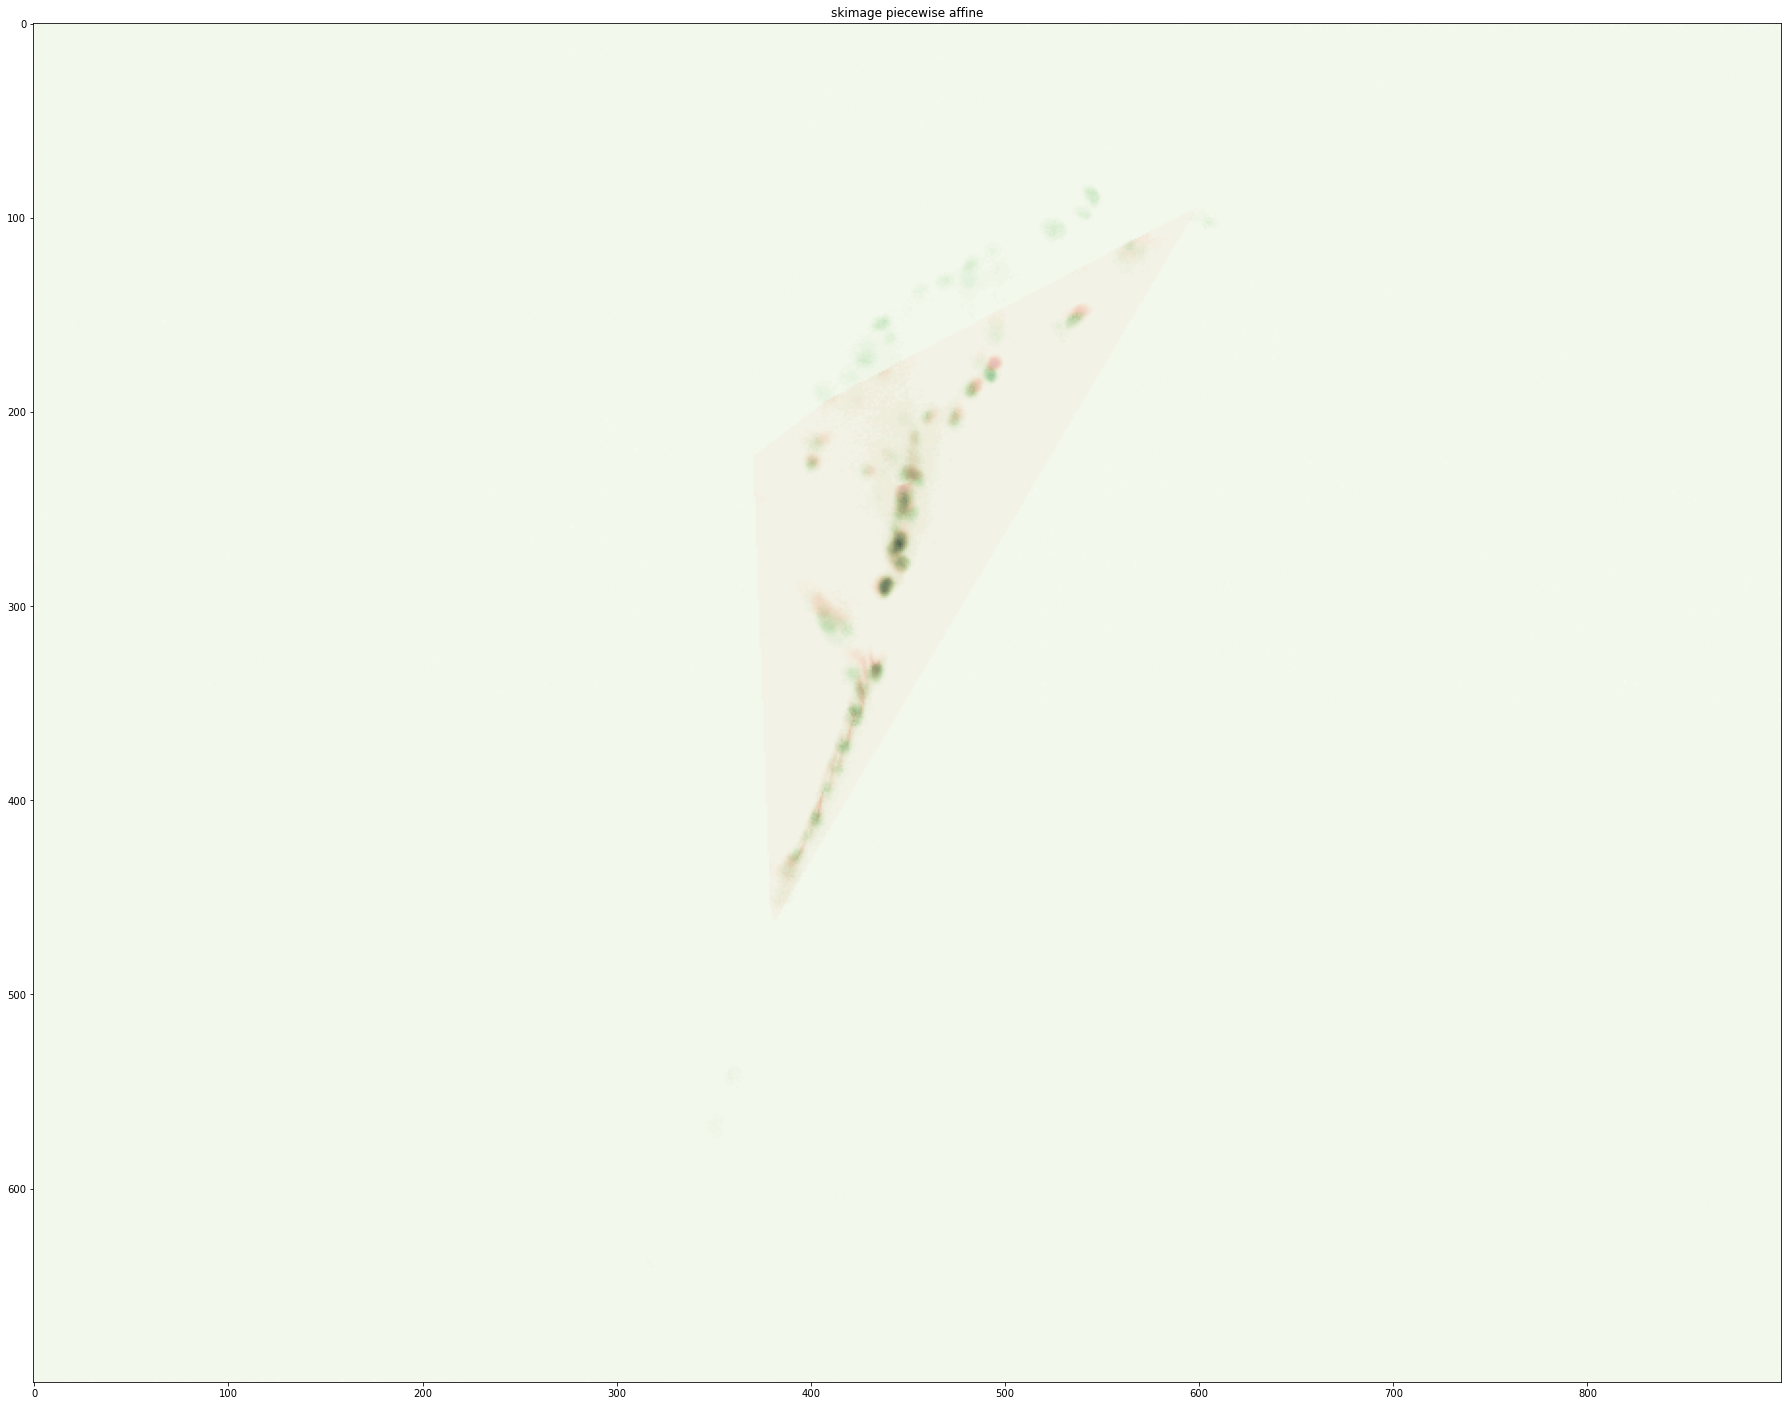

In [194]:
plt.figure(figsize=(45,25))
plt.imshow(out, alpha=0.5, cmap="Reds")
plt.imshow(ref_frame[i_slice,...], alpha=0.5, cmap="Greens")
plt.title("skimage piecewise affine")

# Vector field consensus for removing outliers

In [5]:
import dynamo

  0%|          | 0/32 [00:00<?, ?it/s]

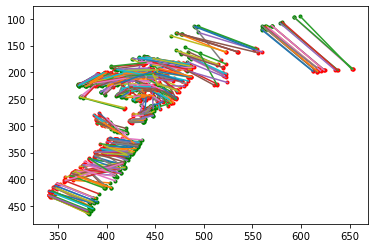

In [334]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import PiecewiseAffineTransform, warp
from skimage import data

# Reuse feature matches
all_locs0, all_locs1, all_kp0, all_kp1, all_matches = build_features_and_match_2volumes(
    ref_frame, test_frame, use_GMS=True, verbose=0, start_plane=2, matches_to_keep=0.5
)
if len(all_locs0) == 0:
    print("No matches found")
zxy0 = np.array(all_locs0[:,1:], dtype='float64')
zxy1 = np.array(all_locs1[:,1:], dtype='float64')
plt.plot(zxy0[:,0], zxy0[:,1], 'g.')
plt.plot(zxy1[:,0], zxy1[:,1], 'r.')
for x0, x1 in zip(zxy0, zxy1):
    plt.plot([x0[0], x1[0]], [x0[1], x1[1]])
plt.gca().invert_yaxis()

In [335]:
# X = zxy0
# Y = zxy1 - zxy0
X = zxy0
Y = zxy1 - zxy0

x = np.arange(ref_frame.shape[1])
y = np.arange(ref_frame.shape[2])
grid = np.array(list(itertools.product(x, y)))

vf = dynamo.vf.SparseVFC(X, Y, grid)


iteration 0

iteration 1

iteration 2

iteration 3

iteration 4

iteration 5

iteration 6

iteration 7

iteration 8

iteration 9

iteration 10

iteration 11

iteration 12

iteration 13

iteration 14

iteration 15

iteration 16


Text(0.5, 1.0, 'Old, rigid flow')

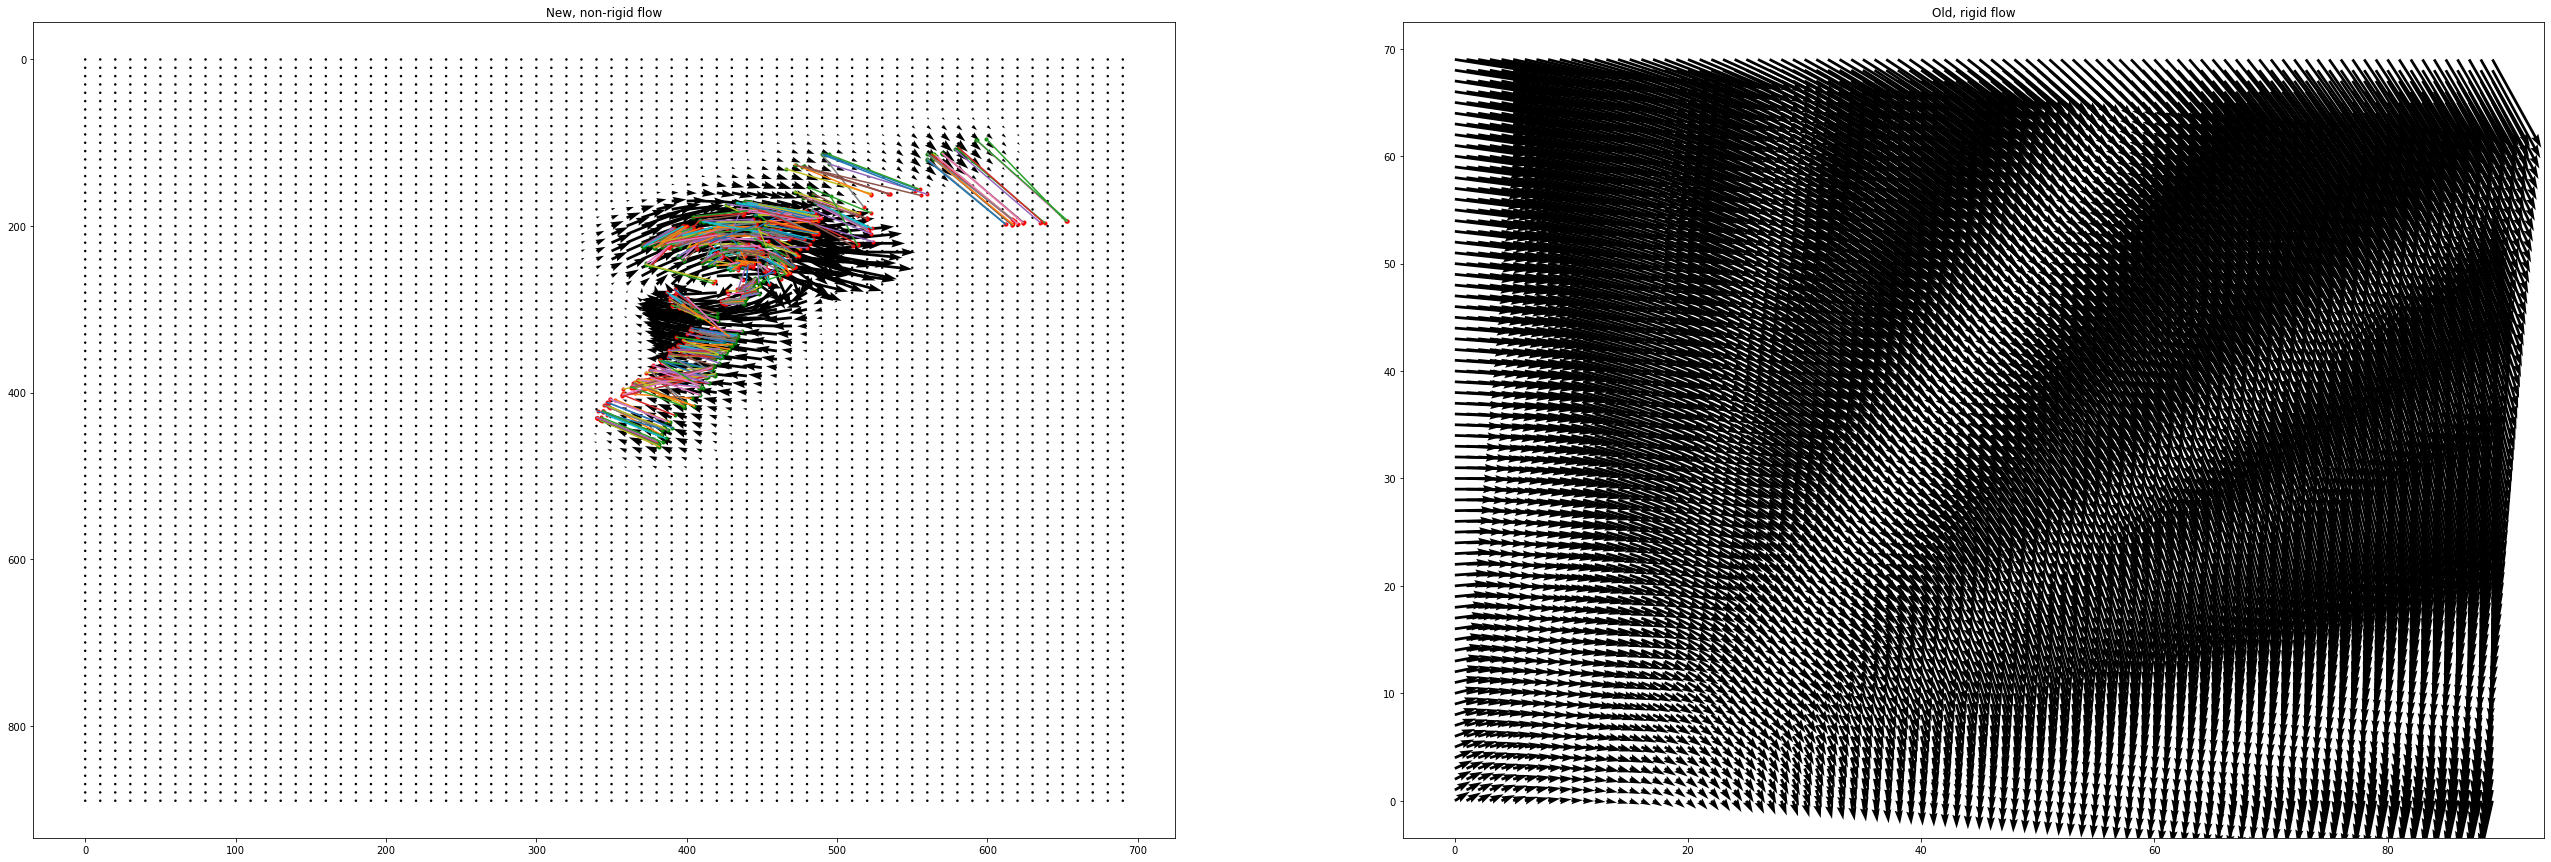

In [338]:
# Actually apply it
flow_long = vf['grid_V']
x, y = ref_frame.shape[1:]
# FLIP XY vectors
flow0 = np.reshape(flow_long[:,0], (x, y))
flow1 = np.reshape(flow_long[:,1], (x, y))
vf_flow = (np.stack([flow0, flow1], axis=2)).astype('float32')

plt.figure(figsize=(45,15))
down = 10
plt.subplot(121)
grid = vf['grid']
X = np.reshape(grid[:,0], (x, y), order='C')
Y = np.reshape(grid[:,1], (x, y), order='C')
X = X[::down, ::down]
Y = Y[::down, ::down]
# tmp = vector_field_to_flow(vf_flow)
tmp = 5e6*vf_flow
U = tmp[::down, ::down, 0]
V = tmp[::down, ::down, 1]
opt = {'angles':'xy', 'scale_units':'xy', 'scale':down}
plt.quiver(X, Y, U, V, **opt)
# plt.quiver(Y, X, U, V, **opt)
plt.title("New, non-rigid flow")

plt.plot(zxy0[:,0], zxy0[:,1], 'g.')
plt.plot(zxy1[:,0], zxy1[:,1], 'r.')
for x0, x1 in zip(zxy0, zxy1):
    plt.plot([x0[0], x1[0]], [x0[1], x1[1]])
    
plt.gca().invert_yaxis()

plt.subplot(122)
down2 = down
vf_old = flow_to_vector_field(flow)
plt.quiver(vf_old[::down2,::down2, 0], vf_old[::down2,::down2, 1], **opt)
plt.title("Old, rigid flow")

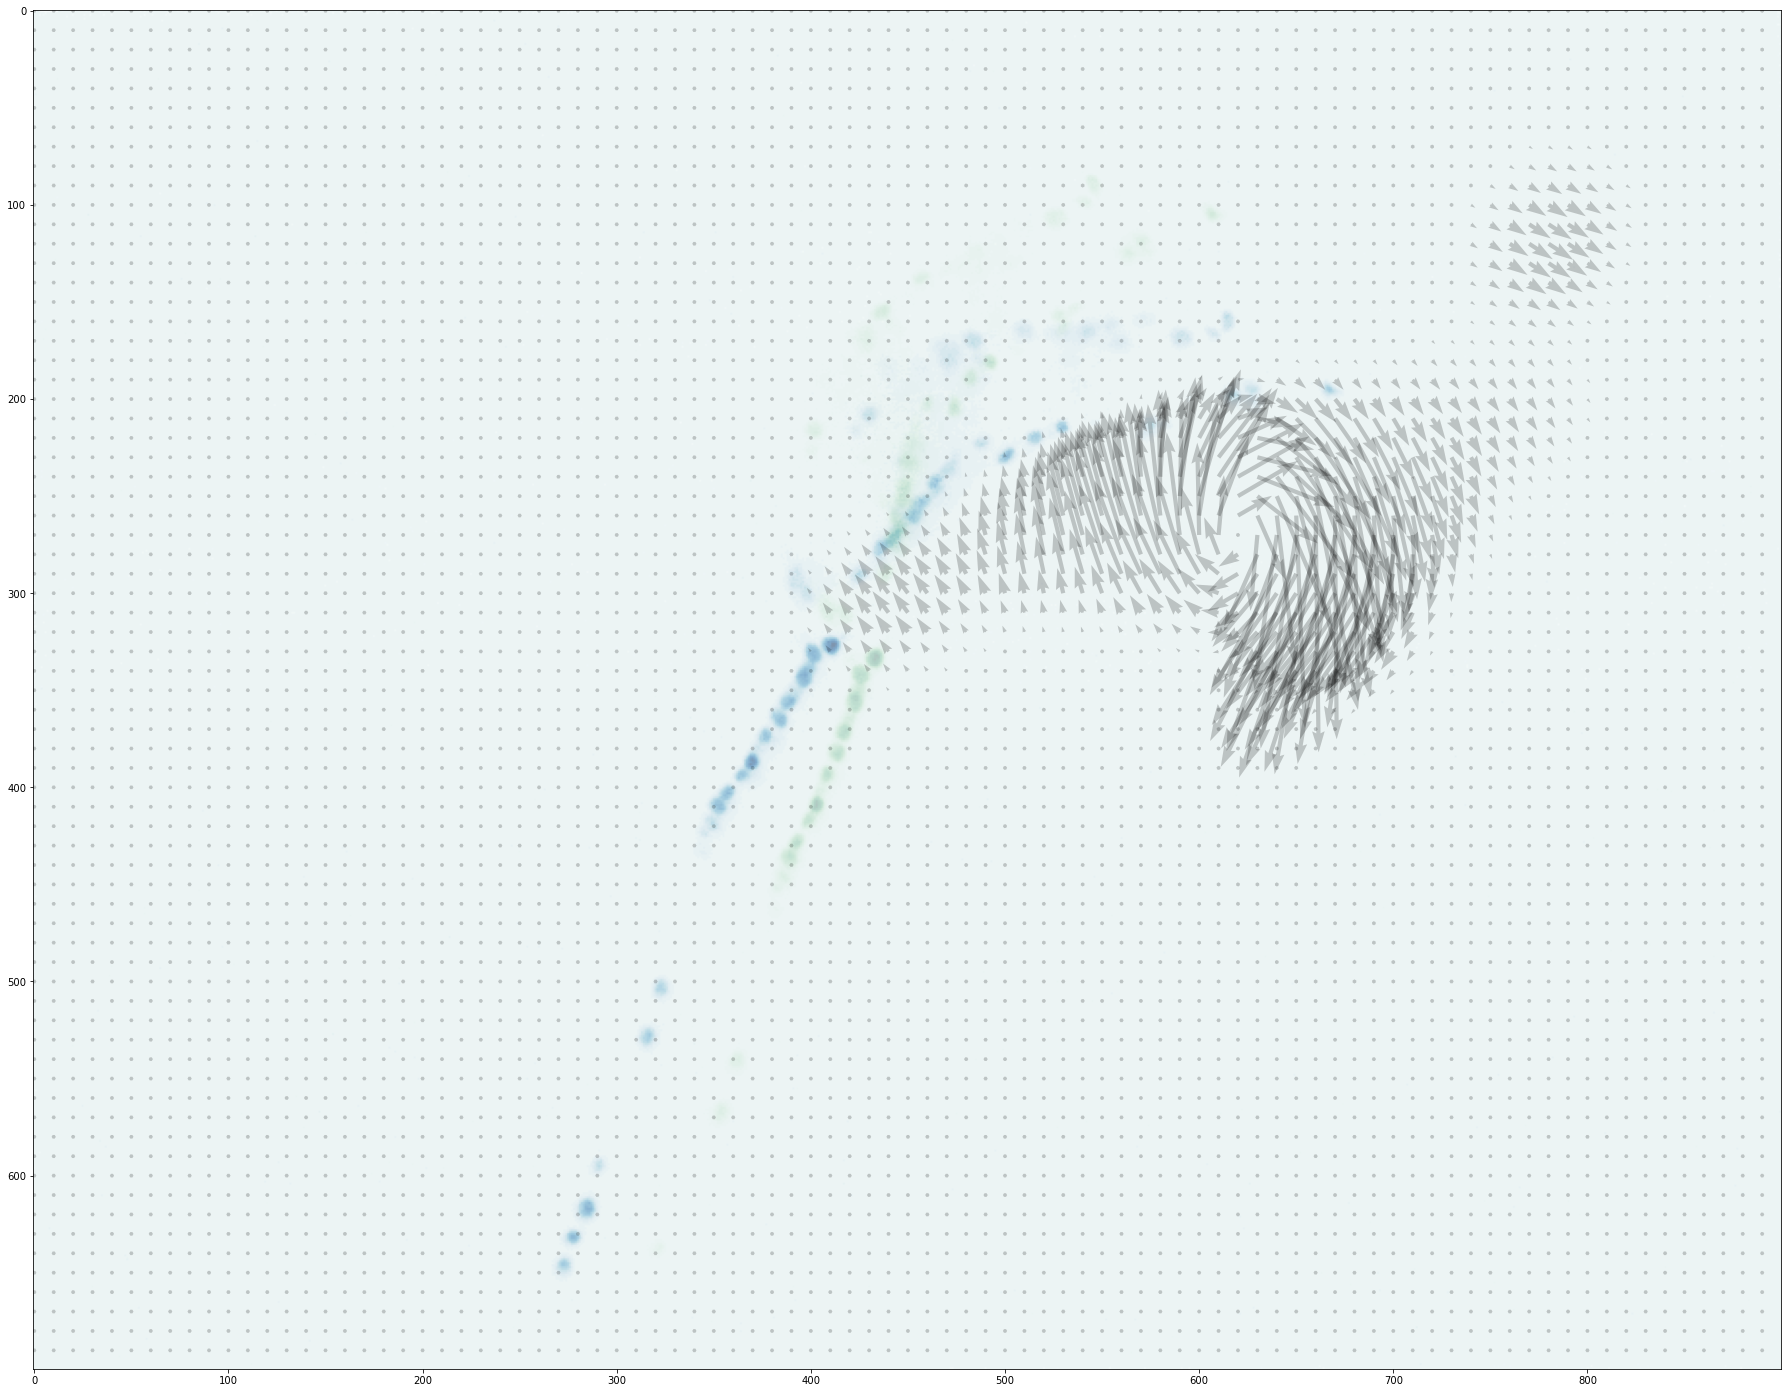

In [339]:
plt.figure(figsize=(45,25))
plt.imshow(ref, alpha=0.5, cmap="Greens")
plt.imshow(img, alpha=0.5, cmap="Blues")
opt = {'angles':'xy', 'scale_units':'xy', 'scale':down, 'alpha':0.2}
plt.quiver(Y, X, np.flipud(np.fliplr(V)), np.flipud(np.fliplr(U)), **opt)

In [340]:
i_slice = 17
img = test_frame[i_slice,...]
ref = ref_frame[i_slice,...]

tmp = -1e8*vf_flow
V2 = tmp[..., 0] # X=cols
U2 = tmp[..., 1] # Y=rows
nr, nc = img.shape
row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')
inverse_map = np.array([col_coords + V2, row_coords + U2]).transpose([1,2,0])

# img_warped = warp_flow(ref, inverse_map.astype('float32'), apply_directly=True)
img_warped = warp_flow(ref, 1e7*vf_flow, apply_directly=False)

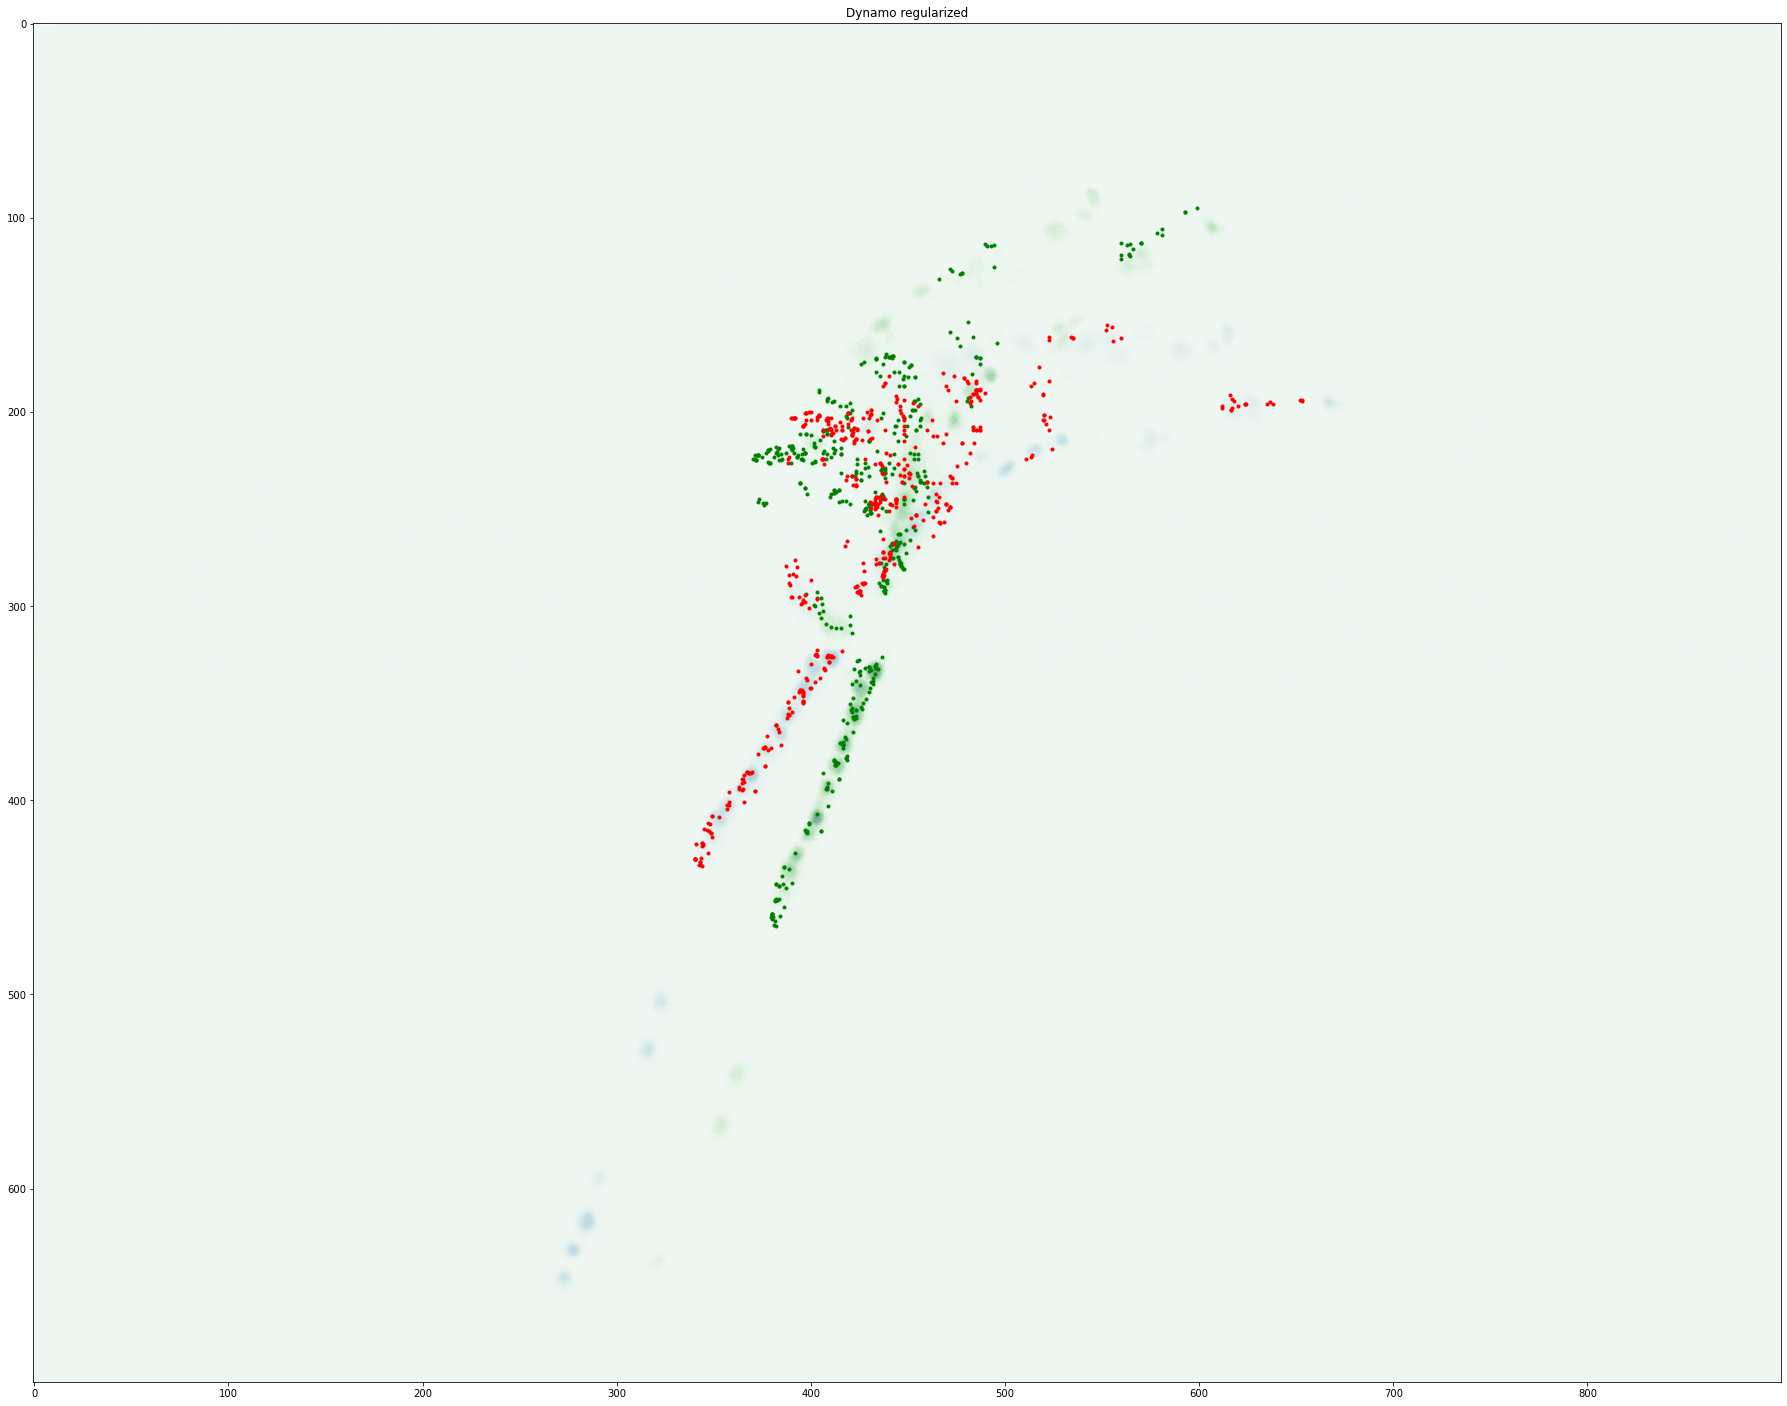

In [345]:
plt.figure(figsize=(45,25))
# plt.imshow(img_warped, alpha=0.5, cmap="Reds")
plt.imshow(img, alpha=0.5, cmap="Blues")
plt.imshow(ref, alpha=0.5, cmap="Greens")
plt.title("Dynamo regularized")
plt.plot(zxy0[:,0], zxy0[:,1], 'g.')
plt.plot(zxy1[:,0], zxy1[:,1], 'r.')
# for x0, x1 in zip(zxy0, zxy1):
#     plt.plot([x0[0], x1[0]], [x0[1], x1[1]])

In [281]:
from skimage.transform import warp

In [258]:
# From: https://scikit-image.org/docs/0.17.x/auto_examples/registration/plot_opticalflow.html
nr, nc = img.shape
row_coords, col_coords = np.meshgrid(np.arange(nr), np.arange(nc),
                                     indexing='ij')

tmp = 1e8*vf_flow
V = tmp[..., 0]
U = tmp[..., 1]

img_warp = warp(img, np.array([row_coords + V, col_coords + U]),
                   mode='nearest')


Text(0.5, 1.0, 'Dynamo regularized')

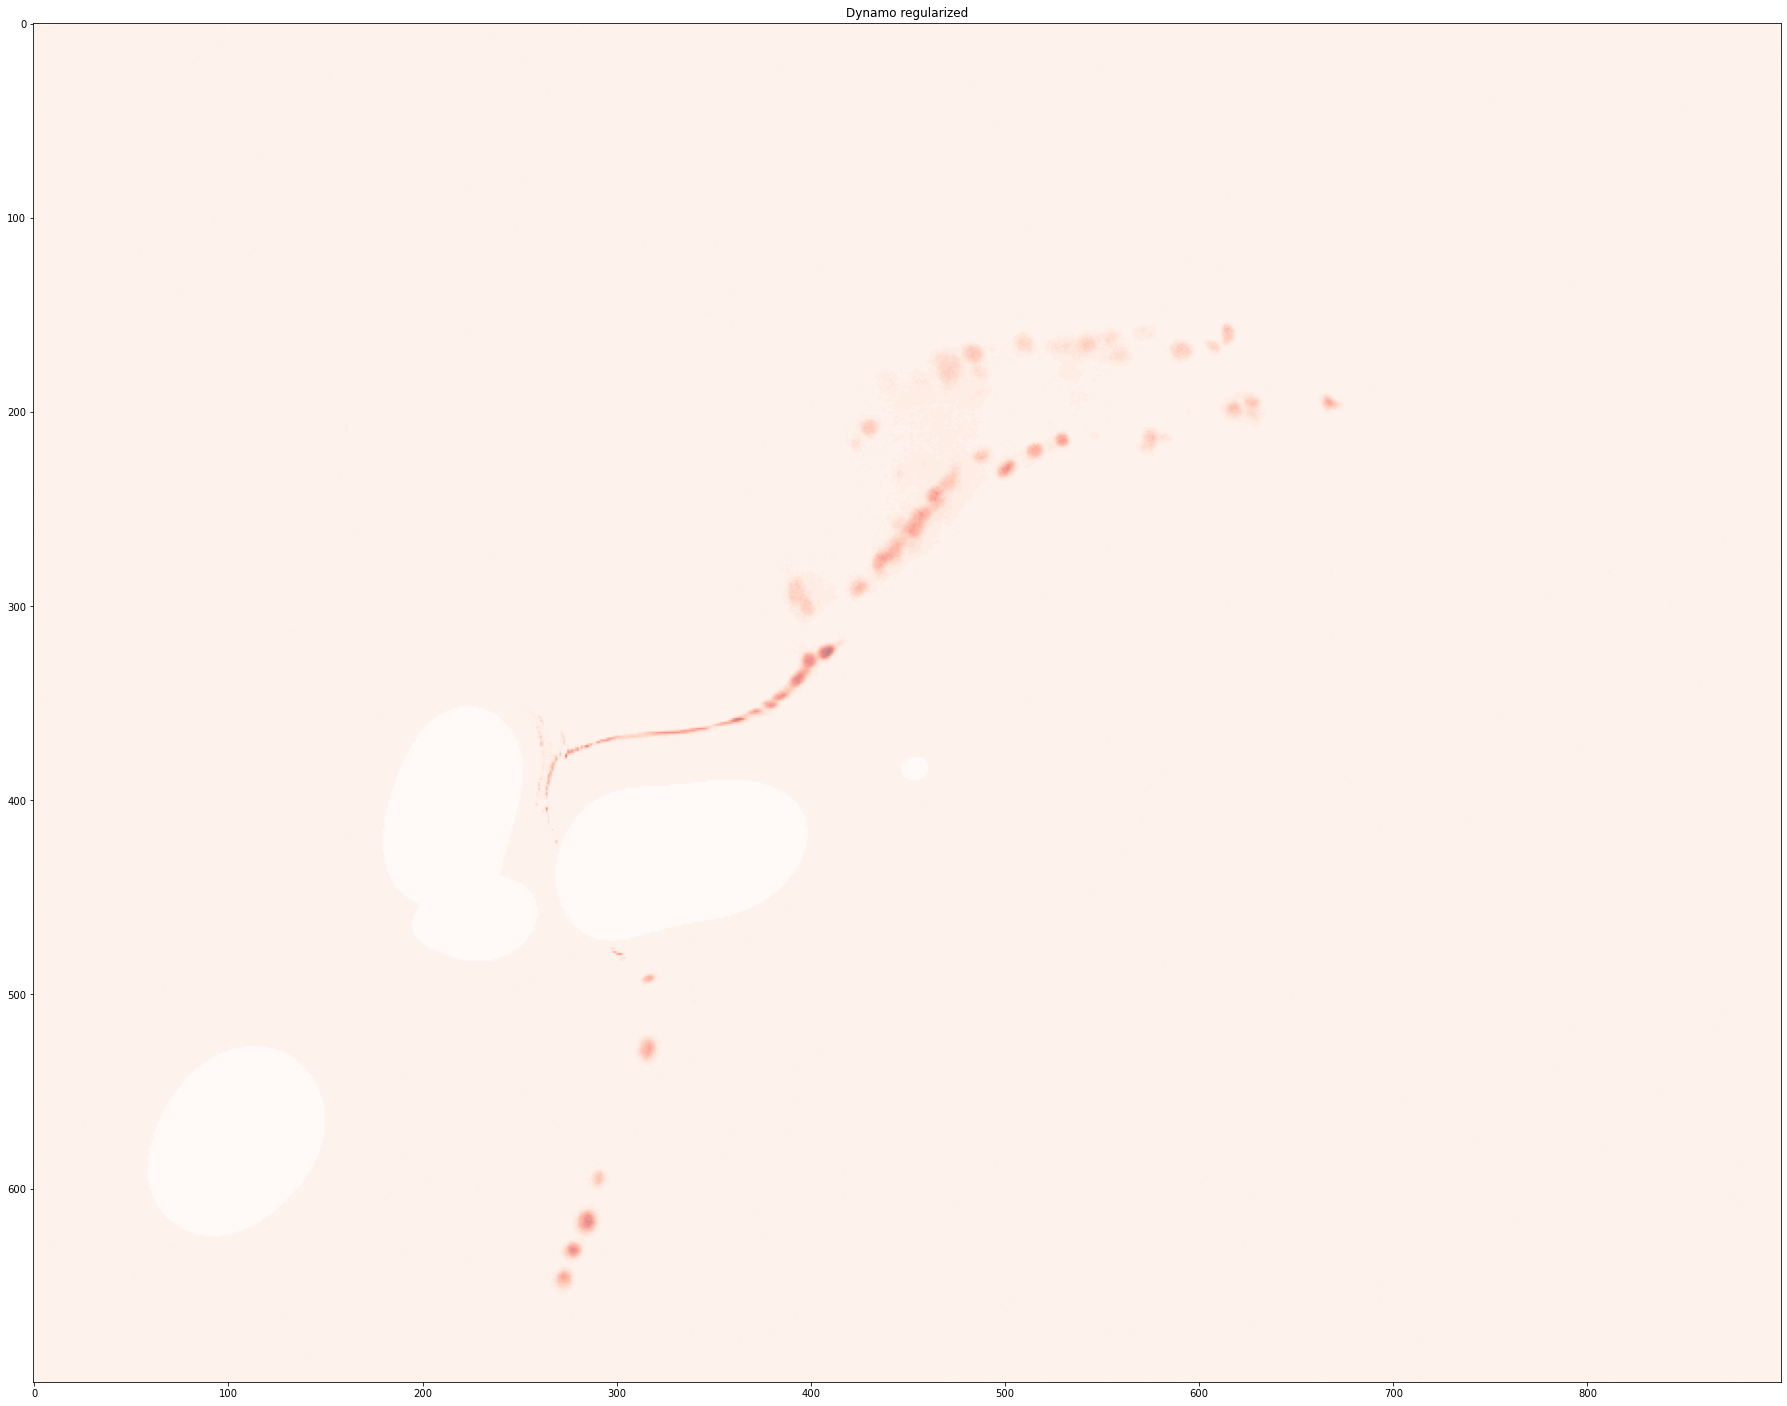

In [259]:
plt.figure(figsize=(45,25))
plt.imshow(img_warped, alpha=0.5, cmap="Reds")
# plt.imshow(img, alpha=0.5, cmap="Blues")
# plt.imshow(ref, alpha=0.5, cmap="Greens")
plt.title("Dynamo regularized")

In [265]:
row_coords, X

(array([[  0,   0,   0, ...,   0,   0,   0],
        [  1,   1,   1, ...,   1,   1,   1],
        [  2,   2,   2, ...,   2,   2,   2],
        ...,
        [697, 697, 697, ..., 697, 697, 697],
        [698, 698, 698, ..., 698, 698, 698],
        [699, 699, 699, ..., 699, 699, 699]]),
 array([[  0,   0,   0, ...,   0,   0,   0],
        [ 10,  10,  10, ...,  10,  10,  10],
        [ 20,  20,  20, ...,  20,  20,  20],
        ...,
        [670, 670, 670, ..., 670, 670, 670],
        [680, 680, 680, ..., 680, 680, 680],
        [690, 690, 690, ..., 690, 690, 690]]))

In [236]:
# Check using example data
from skimage import data, io, filters

image = data.coins()

# plt.imshow(image);

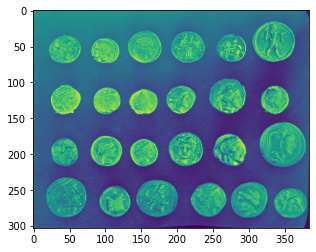

In [237]:
x, y = image.shape
img_warped = warp_flow(image, 1e8*vf_flow[:x, :y], apply_directly=False)
plt.imshow(img_warped)

In [ ]:
# Do ECC matching
# all_warp_mat = []
# ECC_crop = np.zeros_like(rotated_crop)
# for i_plane in range(len(z)-1):
#     ref_plane = ref_crop[i_plane,...]
#     rotated_plane = rotated_crop2[i_plane,...]
# #     mat = calc_warp_ECC(rotated_plane, ref_plane, termination_eps=0.5, warp_mode=cv2.MOTION_AFFINE, number_of_iterations=1000000)
#     ECC_crop[i_plane,...] = cv2.warpAffine(rotated_plane, mat, rotated_plane.shape)
#     all_warp_mat.append(mat)

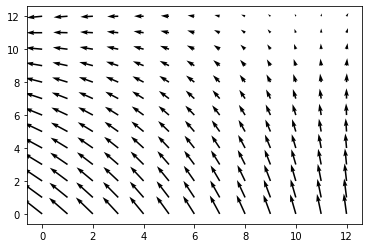

In [328]:
downsample = 10
plt.quiver(flow[::downsample,::downsample,0], flow[::downsample,::downsample,1])

Text(0.5, 1.0, 'Overlay after affine + ECC transformation')

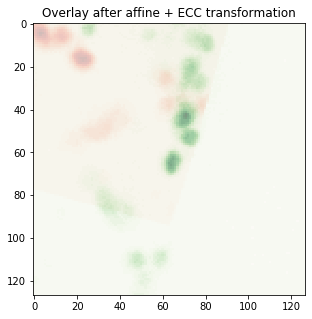

In [329]:
i_slice = 3
plt.figure(figsize=(25,5))
plt.imshow(ECC_crop[i_slice,...], alpha=0.5, cmap="Reds")
plt.imshow(ref_crop[i_slice,...], alpha=0.5, cmap="Greens")
plt.title("Overlay after affine + ECC transformation")